# Sarcasm with Single Layer LSTM

In [1]:
import numpy as np

import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2020-07-09 15:54:24--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.217.128, 173.194.218.128, 108.177.11.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.217.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.03s   

2020-07-09 15:54:24 (163 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [3]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []
urls = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [4]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [5]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)), ###<--- here is the bidirectional LSTM
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 120, 16)           16000     
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                12544     
_________________________________________________________________
dense (Dense)                (None, 24)                1560      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25        
Total params: 30,129
Trainable params: 30,129
Non-trainable params: 0
_________________________________________________________________


In [6]:
num_epochs = 50
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=1)

Epoch 1/50
625/625 [==============================] - 37s 59ms/step - loss: 0.4501 - accuracy: 0.7734 - val_loss: 0.3973 - val_accuracy: 0.8074
Epoch 2/50
625/625 [==============================] - 36s 58ms/step - loss: 0.3555 - accuracy: 0.8378 - val_loss: 0.3822 - val_accuracy: 0.8283
Epoch 3/50
625/625 [==============================] - 36s 58ms/step - loss: 0.3287 - accuracy: 0.8522 - val_loss: 0.3723 - val_accuracy: 0.8328
Epoch 4/50
625/625 [==============================] - 36s 58ms/step - loss: 0.3105 - accuracy: 0.8619 - val_loss: 0.3765 - val_accuracy: 0.8310
Epoch 5/50
625/625 [==============================] - 36s 57ms/step - loss: 0.2977 - accuracy: 0.8694 - val_loss: 0.3740 - val_accuracy: 0.8325
Epoch 6/50
625/625 [==============================] - 36s 57ms/step - loss: 0.2861 - accuracy: 0.8751 - val_loss: 0.3999 - val_accuracy: 0.8249
Epoch 7/50
625/625 [==============================] - 36s 57ms/step - loss: 0.2782 - accuracy: 0.8777 - val_loss: 0.3895 - val_accuracy:

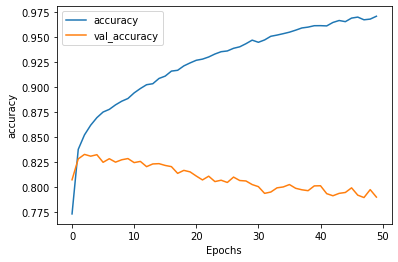

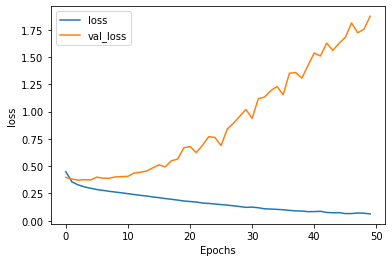

In [7]:
import matplotlib.pyplot as plt

def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [8]:
model.save("test.h5")